# Определение перспективного тарифа для телеком компании

### Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, **какой тариф приносит больше денег.**

Вам предстоит сделать **предварительный анализ тарифов на небольшой выборке клиентов**. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать **вывод — какой тариф лучше**.

### Описание тарифов
#### Тариф «Смарт»
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
    * минута разговора: 3 рубля
    * сообщение: 3 рубля
    * 1 Гб интернет-трафика: 200 рублей

#### Тариф «Ультра»
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
    * минута разговора: 1 рубль
    * сообщение: 1 рубль
    * 1 Гб интернет-трафика: 150 рублей
    
*NB: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.*

----

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored
from scipy import stats as st
pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
sns.set(style = 'whitegrid', font_scale=2)
colors = ['darkorange','grey', 'crimson', 'turquoise']

sns.set_style('darkgrid',
              {'axes.facecolor': '0.95',
               'axes.edgecolor': '0.05',
               'axes.labelcolor': '1',
               'text.color': '1',
               'xtick.color': '1',
               'ytick.color': '1',
               'grid.color': '0.1',
               'figure.facecolor': '0.6'})

sns.set_context('notebook', font_scale=1.3)

In [3]:
def plot_hist_and_box_for_column(data=None,
                                 column_name=None,
                                 bins=50,
                                 figsize=(10,5),
                                 label='',
                                 palette='viridis',
                                 ):
    
    '''
    полезная для EDA функция
    рисует гистограмму и боксплот для значений столбца друг под другом
    label - можно добавить размерность к названию столбца в названии оси
    '''
    
    fig, ax = plt.subplots(2,1, figsize=figsize, sharex=True)
    sns.histplot(data=data, x=column_name, bins=bins, palette=palette, ax=ax[0])
    sns.boxenplot(x=column_name,
                  data=data,
                  palette=palette,
                  width = 0.4,
                  ax=ax[1],
                 )
    ax[1].set_xlabel(column_name+label) 
    sns.despine()
    plt.suptitle('Распределение значений `'+column_name+'`')
    return(plt.show)

In [4]:
def bold(str):
    return '\033[1m' + str + "\033[0;0m"

----

# Предобработка данных

In [5]:
calls = pd.read_csv('datasets/calls.csv')
internet = pd.read_csv('datasets/internet.csv', index_col=0)
messages = pd.read_csv('datasets/messages.csv')
tariffs = pd.read_csv('datasets/tariffs.csv')
users = pd.read_csv('datasets/users.csv')

## Таблица users (информация о пользователях):
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

In [6]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [7]:
users.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 229.6 KB


In [8]:
print(bold('Количество пропущенных значений в столбцах:'), '\n', users.isnull().sum())

Количество пропущенных значений в столбцах: 
 user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64


Пустые значения только в дате отключения. Это хорошо, значит, пользователь еще с нами.

Изменим тип данных в столбцах с датами:

In [9]:
users['churn_date'] = pd.to_datetime(users['churn_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])

In [10]:
print(bold('Типы данных в столбцах:'), '\n', users.dtypes, sep='')

Типы данных в столбцах:
user_id                int64
age                    int64
churn_date    datetime64[ns]
city                  object
first_name            object
last_name             object
reg_date      datetime64[ns]
tariff                object
dtype: object


In [11]:
print(bold('Число дублирующихся строк:'), users.duplicated().sum())
print(bold('Идентификаторы всех пользователей уникальны:'), users['user_id'].nunique() == len(users))

Число дублирующихся строк: 0
Идентификаторы всех пользователей уникальны: True


Посмотрим, как выглядит гистограмма возраста клиентов, нет ли аномалий, репрезентативная ли выборка:

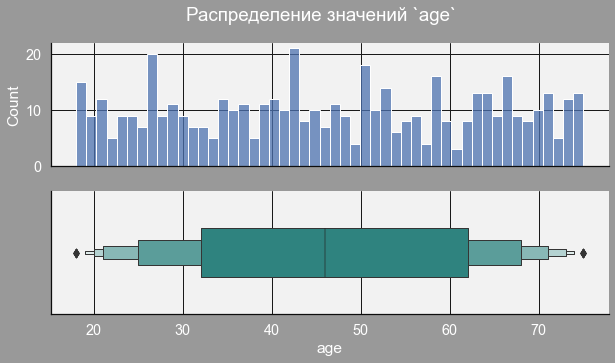

In [12]:
plot_hist_and_box_for_column(data=users,
                             column_name='age',
                             bins=50)
plt.show()

In [13]:
users.age.describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

Значения в колонке возраста распределены без аномалий. Самому молодому пользователю 18 лет, самому пожилому 75. При этом бины на гистограме не сильно различаются по высоте, значит выборка репрезентативна по признаку возраста.

Сделаем небольшое переименование в столбцах:

In [14]:
users = users.rename(columns={'tariff':'tariff_name'})

А так же удалим ненужные столбцы с персональной информацией - имя и фамилия, для нас они не информативны:

In [15]:
users = users.drop(['first_name','last_name'], axis=1)

In [16]:
users.head(3)

,user_id,age,churn_date,city,reg_date,tariff_name
0,1000,52,NaT,Краснодар,2018-05-25,ultra
1,1001,41,NaT,Москва,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,2018-06-17,smart


## Таблица calls (информация о звонках):
* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах
* `user_id` — идентификатор пользователя, сделавшего звонок

In [17]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [18]:
calls.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 28.6 MB


In [19]:
print(bold('Количество пропущенных значений в столбцах:'), '\n', calls.isnull().sum(), sep='')
print(bold('Количество дублирующихся строк:'), calls.duplicated().sum())
print(bold('Идентификаторы всех звонков уникальны:'), calls.id.nunique() == len(calls))

Количество пропущенных значений в столбцах:
id           0
call_date    0
duration     0
user_id      0
dtype: int64
Количество дублирующихся строк: 0
Идентификаторы всех звонков уникальны: True


Мы знаем, что тарификация идет даже за неполную минуту разговора, тогда можно окрулить вверх все значения длительности и привести столбец к типу int:

In [20]:
calls['duration'] = np.ceil(calls['duration']).astype('int')

Также сменим тип данных столбца с датами:

In [21]:
calls['call_date'] = pd.to_datetime(calls['call_date'])

In [22]:
print(bold('Типы данных в столбцах:'), '\n', calls.dtypes, sep='')

Типы данных в столбцах:
id                   object
call_date    datetime64[ns]
duration              int64
user_id               int64
dtype: object


Посмотрим, как распределены значения длительности звонков.

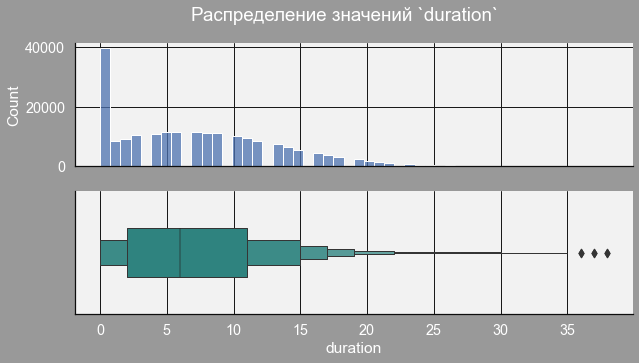

In [23]:
plot_hist_and_box_for_column(data=calls,
                             column_name='duration',
                             bins=50)
plt.show()

Много звонков с нулевой длительностью: возможно, стуация такая, что клиент звонил, но трубку на том конце не сняли. Удалим такие значения, потому что они будут влиять на подсчет числа звонков, но не на их длительность. Такие звонки не приносят денег компании. В реальном бизнесе, я думаю, что нужно задать вопрос разработчикам про данные с нулевой длительностью.

In [24]:
calls = calls[calls['duration'] > 0].reset_index(drop=True)

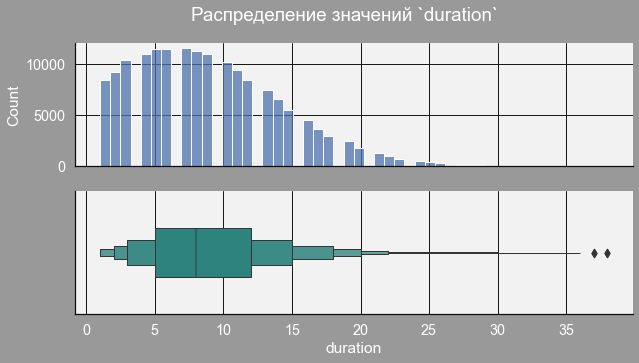

In [25]:
plot_hist_and_box_for_column(data=calls,
                             column_name='duration',
                             bins=50)
plt.show()

In [26]:
calls['duration'].describe()

count    162994.000000
mean          8.897880
std           5.353761
min           1.000000
25%           5.000000
50%           8.000000
75%          12.000000
max          38.000000
Name: duration, dtype: float64

Медианное время звонка - 8 минут, но есть и короткие по 1 минуте (на самом деле длительность меньше, но тарификация идет как за целую минуту), и длинные звонки - по 38 минут.

Небольшое переименование. Переименования делаем для того, чтобы потом удобно было делать сводные таблицы и объединять их друг с другом.

In [27]:
calls = calls.rename(columns={'id':'call_id'})

In [28]:
calls.head(3)

,call_id,call_date,duration,user_id
0,1000_2,2018-06-11,3,1000
1,1000_3,2018-09-21,14,1000
2,1000_4,2018-12-15,6,1000


## Таблица messages (информация о сообщениях):
* `id` — уникальный номер сообщения
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение

In [29]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [30]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [31]:
print(bold('Количество пропущенных значений в столбцах:'), '\n', messages.isnull().sum(), sep='')
print(bold('Количество дублирующихся строк:'), messages.duplicated().sum())
print(bold('Идентификаторы всех сообщений уникальны:'), messages.id.nunique() == len(messages))

Количество пропущенных значений в столбцах:
id              0
message_date    0
user_id         0
dtype: int64
Количество дублирующихся строк: 0
Идентификаторы всех сообщений уникальны: True


Меняем тип данных в столбце с датами:

In [32]:
messages['message_date'] = pd.to_datetime(messages['message_date'])

In [33]:
print(bold('Типы данных в столбцах:'), '\n', messages.dtypes, sep='')

Типы данных в столбцах:
id                      object
message_date    datetime64[ns]
user_id                  int64
dtype: object


Снова переименовываем столбец `id`:

In [34]:
messages = messages.rename(columns={'id':'message_id'})
messages.head()

,message_id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


## Таблица internet (информация об интернет-сессиях):
* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя

In [35]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [36]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [37]:
print(bold('Количество пропущенных значений в столбцах:'), '\n', internet.isnull().sum(), sep='')
print(bold('Количество дублирующихся строк:'), internet.duplicated().sum())
print(bold('Идентификаторы всех сессий уникальны:'), internet.id.nunique() == len(internet))

Количество пропущенных значений в столбцах:
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64
Количество дублирующихся строк: 0
Идентификаторы всех сессий уникальны: True


Аналогично минутам округлим мегабайты и сменим тип данных столбца с датой:

In [38]:
internet['mb_used'] = np.ceil(internet['mb_used']).astype('int')
internet['session_date'] = pd.to_datetime(internet['session_date'])

In [39]:
print(bold('Типы данных в столбцах:'), '\n', internet.dtypes, sep='')

Типы данных в столбцах:
id                      object
mb_used                  int64
session_date    datetime64[ns]
user_id                  int64
dtype: object


Посмотрим, как распределены значения столбца `mb_used`:

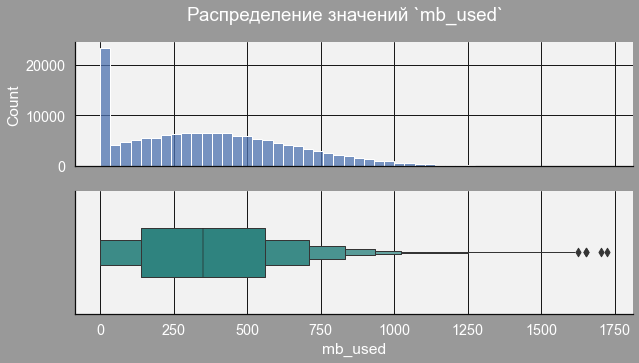

In [40]:
plot_hist_and_box_for_column(data=internet,
                             column_name='mb_used',
                             bins=50)
plt.show()

Много нулевых, но так как нам важно не количество сессий, а их трафик, нулевые значения ни на что не влияют, то мы их оставим.

И опять переименовываем столбец `id`:

In [41]:
internet = internet.rename(columns={'id':'session_id'})
internet.head(3)

,session_id,mb_used,session_date,user_id
0,1000_0,113,2018-11-25,1000
1,1000_1,1053,2018-09-07,1000
2,1000_2,1198,2018-06-25,1000


## Таблица tariffs (информация о тарифах):
* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [42]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [43]:
tariffs.dtypes

messages_included         int64
mb_per_month_included     int64
minutes_included          int64
rub_monthly_fee           int64
rub_per_gb                int64
rub_per_message           int64
rub_per_minute            int64
tariff_name              object
dtype: object

Переведем трафик в гигабайты, потому что абоненты будут доплачивать за каждый целый гигабайт вне тарифа.

In [44]:
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included']/1024
tariffs = tariffs.rename(columns={'mb_per_month_included':'gb_per_month_included'})

Эта таблица содержит информацию об условиях тарифа. Добавим ее к таблице с пользователями, чтобы для каждого конкретного пользователя наглядно видеть, на каких условиях ему оказывается обслуживание:

In [45]:
joined_data = users.merge(tariffs, on='tariff_name')
joined_data.head()

,user_id,age,churn_date,city,reg_date,tariff_name,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaT,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
1,1003,23,NaT,Москва,2018-08-17,ultra,1000,30.0,3000,1950,150,1,1
2,1004,68,NaT,Новокузнецк,2018-05-14,ultra,1000,30.0,3000,1950,150,1,1
3,1013,36,NaT,Иваново,2018-11-14,ultra,1000,30.0,3000,1950,150,1,1
4,1016,58,NaT,Омск,2018-11-21,ultra,1000,30.0,3000,1950,150,1,1


----

## Агрегация данных по звонкам, сообщениям и интернет-сессиям для каждого абонента по месяцам

**Для каждого пользователя посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам.** Для этого сделаем сводную таблицу из `calls`, где группировать будет по id абонента и по месяцу.

In [46]:
calls['call_month'] = calls['call_date'].dt.month

In [47]:
calls_pivot = calls.pivot_table(index=['user_id', 'call_month'], values='duration', aggfunc=['count', 'sum']).reset_index()
calls_pivot.columns = ['user_id', 'month', 'count_calls', 'minutes_used']
print(len(calls_pivot))
calls_pivot.head(10)

3168


,user_id,month,count_calls,minutes_used
0,1000,5,17,159
1,1000,6,28,172
2,1000,7,41,340
3,1000,8,42,408
4,1000,9,46,466
5,1000,10,44,350
6,1000,11,37,338
7,1000,12,38,333
8,1001,11,45,430
9,1001,12,47,414


In [48]:
calls_pivot.dtypes

user_id         int64
month           int64
count_calls     int64
minutes_used    int64
dtype: object

Теперь мы видим какой абонент в какой месяц сколько звонков сделал и сколько потратил минут.

**Для каждого пользователя посчитаем количество отправленных сообщений по месяцам.** Для этого теперь сделаем сводную таблицу из `messages`, где группировать будем по id абонента и по месяцу.

In [49]:
messages['message_month'] = messages['message_date'].dt.month
messages_pivot = messages.pivot_table(index=['user_id', 'message_month'], values='message_id', aggfunc=['count']).reset_index()
messages_pivot.columns = ['user_id', 'month', 'messages_used']
messages_pivot.head(10)

,user_id,month,messages_used
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


In [50]:
messages_pivot.dtypes

user_id          int64
month            int64
messages_used    int64
dtype: object

Теперь мы видим какой абонент в какой месяц сколько смс отправил. Объединим эту информацию со сводной информацией по звонкам:

In [51]:
joined_pivot = calls_pivot.merge(messages_pivot, on=['user_id', 'month'], how='outer')
# используем  how='outer' чтобы если какого-то сочетания пользователь-месяц в сводной таблице по звонкам нет,
# они не потерялись
print(len(joined_pivot))
joined_pivot.head()

3212


,user_id,month,count_calls,minutes_used,messages_used
0,1000,5,17.0,159.0,22.0
1,1000,6,28.0,172.0,60.0
2,1000,7,41.0,340.0,75.0
3,1000,8,42.0,408.0,81.0
4,1000,9,46.0,466.0,57.0


Наконец, **для каждого пользователя посчитаем объем израсходованного интернет-трафика по месяцам.** Для этого сделаем сводную таблицу из `internet`, где группировать снова будем по id абонента и по месяцу.

In [52]:
internet['session_month'] = internet['session_date'].dt.month

internet_pivot = internet.pivot_table(index=['user_id', 'session_month'], values='mb_used', aggfunc=['sum']).reset_index()
internet_pivot.columns = ['user_id', 'month', 'mb_used']
internet_pivot.head(10)

,user_id,month,mb_used
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581
5,1000,10,14717
6,1000,11,14768
7,1000,12,9827
8,1001,11,18452
9,1001,12,14053


Теперь мы видим, какой абонент в какой месяц сколько мегабайт потратил. Тарификация у компании идет за гигабайты, так что, чтобы было потом удобно сравнивать значения с теми, что включены в пакет, переведем эту колонку в Гб:

In [53]:
internet_pivot['mb_used'] = np.ceil(internet_pivot['mb_used'] / 1024)
internet_pivot.columns = ['user_id', 'month', 'gb_used']
internet_pivot.head()

,user_id,month,gb_used
0,1000,5,3.0
1,1000,6,23.0
2,1000,7,14.0
3,1000,8,14.0
4,1000,9,15.0


!!! Таким образом округлили 2 раза - сначала Мб, потом Гб.

Объединим эту информацию со сводной информацией по звонкам и смс:

In [54]:
joined_pivot = joined_pivot.merge(internet_pivot, on=['user_id', 'month'], how='outer')
# используем  how='outer' чтобы если какого-то сочетания пользователь-месяц в сводной таблице по звонкам и смс нет,
# они не потерялись
print(len(joined_pivot))
joined_pivot.head()

3214


,user_id,month,count_calls,minutes_used,messages_used,gb_used
0,1000,5,17.0,159.0,22.0,3.0
1,1000,6,28.0,172.0,60.0,23.0
2,1000,7,41.0,340.0,75.0,14.0
3,1000,8,42.0,408.0,81.0,14.0
4,1000,9,46.0,466.0,57.0,15.0


In [55]:
joined_pivot.isnull().sum()

user_id            0
month              0
count_calls       46
minutes_used      46
messages_used    497
gb_used           11
dtype: int64

Видим, что есть пользователи, которые в какие-то месяцы (а может и никогда) не пользовались одной или несколькими услугами. Заполним здесь пустые значения нулями:

In [56]:
joined_pivot = joined_pivot.fillna(0)

Теперь эту информацию можно добавить в таблицу `joined_data`, которая сейчас представляет собой расширенную версию таблицы `users`, куда добавлена подробная информация о тарифе для каждого пользователя:

In [57]:
print(len(joined_data))
joined_data.head()

500


,user_id,age,churn_date,city,reg_date,tariff_name,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaT,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
1,1003,23,NaT,Москва,2018-08-17,ultra,1000,30.0,3000,1950,150,1,1
2,1004,68,NaT,Новокузнецк,2018-05-14,ultra,1000,30.0,3000,1950,150,1,1
3,1013,36,NaT,Иваново,2018-11-14,ultra,1000,30.0,3000,1950,150,1,1
4,1016,58,NaT,Омск,2018-11-21,ultra,1000,30.0,3000,1950,150,1,1


In [58]:
joined_data = joined_data.merge(joined_pivot, on='user_id', how='outer')
print(len(joined_data))
joined_data.head()

3216


,user_id,age,churn_date,city,reg_date,tariff_name,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month,count_calls,minutes_used,messages_used,gb_used
0,1000,52,NaT,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,5.0,17.0,159.0,22.0,3.0
1,1000,52,NaT,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,6.0,28.0,172.0,60.0,23.0
2,1000,52,NaT,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,7.0,41.0,340.0,75.0,14.0
3,1000,52,NaT,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,8.0,42.0,408.0,81.0,14.0
4,1000,52,NaT,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,9.0,46.0,466.0,57.0,15.0


Число строк существенно увеличилось, потому каждый пользователь теперь еще "разбит" по месяцам.

Посмотрим на пустые значения:

In [59]:
joined_data.isnull().sum()

user_id                     0
age                         0
churn_date               3027
city                        0
reg_date                    0
tariff_name                 0
messages_included           0
gb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
month                       2
count_calls                 2
minutes_used                2
messages_used               2
gb_used                     2
dtype: int64

In [60]:
joined_data[joined_data.month.isnull()]

,user_id,age,churn_date,city,reg_date,tariff_name,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month,count_calls,minutes_used,messages_used,gb_used
243,1128,51,2018-12-23,Волжский,2018-12-15,ultra,1000,30.0,3000,1950,150,1,1,NaN,NaN,NaN,NaN,NaN
2619,1371,50,2018-12-30,Омск,2018-12-25,smart,50,15.0,500,550,200,3,3,NaN,NaN,NaN,NaN,NaN


Есть два пользователя, по которым нет вообще никакой статистики. Получается, они не пользовались вообще сетью. Проверим это по исходным таблицам:

In [61]:
print(len(calls[calls['user_id'].isin([1128,1371])]))
print(len(messages[messages['user_id'].isin([1128,1371])]))
print(len(internet[internet['user_id'].isin([1128,1371])]))

0
0
0


Удалим этих пользователей из `joined_data`:

In [62]:
joined_data = joined_data.dropna(subset=['month'])
joined_data.isnull().sum()

user_id                     0
age                         0
churn_date               3027
city                        0
reg_date                    0
tariff_name                 0
messages_included           0
gb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
month                       0
count_calls                 0
minutes_used                0
messages_used               0
gb_used                     0
dtype: int64

----

# Подсчет денег

**Вычислим помесячную выручку с каждого пользователя**

In [63]:
def count_charge(row):
    '''функция для строки, которая для каждого абонента считает'''
    fee = row['rub_monthly_fee']
    # абонентская плата пользователя
    included_in_fee = ['minutes_included', 'messages_included', 'gb_per_month_included']
    # включенные в пакет минуты/смс/гб
    charge_over_included = ['rub_per_minute','rub_per_message','rub_per_gb']
    # стоимость минуты/смс/гб вне пакета (за 1 шт)
    total_used = ['minutes_used', 'messages_used', 'gb_used']
    # суммарное использованное абонентом количество минут/смс/гб  
    charge = fee #минимальная плата = размеру абонентской
    for included, charge_over, used in zip(included_in_fee, charge_over_included, total_used):
        if row[used] > row[included]: # если истраченных минут/смс/гб больше, чем в тарифе
            charge +=  (row[used] - row[included])*row[charge_over]
            # добавим к плате разность умноженную на стоимость 1 шт
    return charge

In [64]:
joined_data['revenue'] = joined_data.apply(count_charge, axis=1)

In [65]:
joined_data.head()

,user_id,age,churn_date,city,reg_date,tariff_name,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month,count_calls,minutes_used,messages_used,gb_used,revenue
0,1000,52,NaT,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,5.0,17.0,159.0,22.0,3.0,1950.0
1,1000,52,NaT,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,6.0,28.0,172.0,60.0,23.0,1950.0
2,1000,52,NaT,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,7.0,41.0,340.0,75.0,14.0,1950.0
3,1000,52,NaT,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,8.0,42.0,408.0,81.0,14.0,1950.0
4,1000,52,NaT,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,9.0,46.0,466.0,57.0,15.0,1950.0


----

# Анализ поведения клиентов

Посмотрим, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Для этого посчитаем выборочные среднее, дисперсию и стандартное отклонение этих значений, а так же построим гистограммы, которые отражают плотность частот (выборочных вероятностей).

In [66]:
ultra_data = joined_data.query('tariff_name == "ultra"')
smart_data = joined_data.query('tariff_name == "smart"')

In [67]:
def count_stats(col):
    '''маленькая локальная функция, чтобы просто не писать одно и то же для разных столбцов'''
    stats = pd.DataFrame({
    'smart': [smart_data[col].mean(), smart_data[col].var(ddof=1), smart_data[col].std(ddof=1)],
    'ultra': [ultra_data[col].mean(), ultra_data[col].var(ddof=1), ultra_data[col].std(ddof=1)]
    },
     index=['выборочное среднее', 'выборочная дисперсия', 'выборочное стандартное отклонение']
    )
    stats = stats.round(1)
    return stats

In [68]:
def show_stats_and_hist(col, title, xlim):
    '''и еще одна функция для вывода статистики и гистограммы на экран'''
    print(colored(title, 'green', attrs=['bold']))
    print(count_stats(col))

    fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True)
    sns.histplot(data=joined_data,
                 x=col,
                 hue='tariff_name',
                 stat='density',
                 bins=100,
                 palette='viridis',
                 ax=ax[0])
    ax[0].legend(['smart','ultra'], facecolor='0.5')
    sns.boxenplot(x=col,
                  y='tariff_name',
                  data=joined_data,
                  palette='viridis',
                  width = 0.4,
                  ax=ax[1],
                 )
    ax[1].set_xticks(xlim)
    sns.despine()
    plt.suptitle('Распределение значений `'+col+'`')
    plt.show()

Длительность разговоров за месяц для абонентов разных тарифов
                                     smart     ultra
выборочное среднее                   417.9     526.6
выборочная дисперсия               36219.3  100873.6
выборочное стандартное отклонение    190.3     317.6


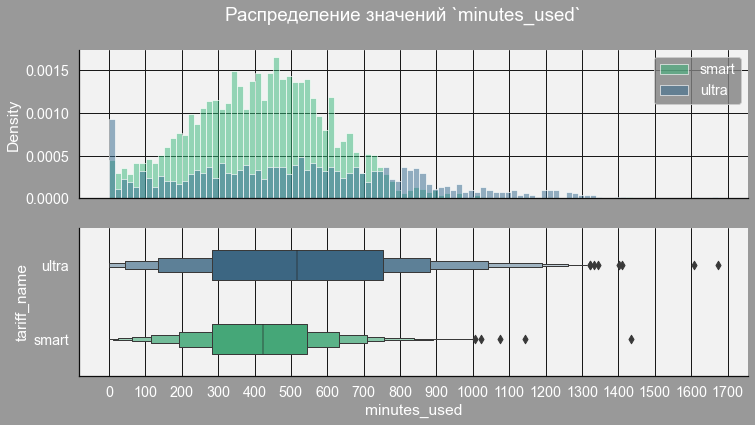

In [69]:
col = 'minutes_used'
title = 'Длительность разговоров за месяц для абонентов разных тарифов'
xlim = np.arange(0,1750,100)
show_stats_and_hist(col, title, xlim)

**Длительность звонков**
Пользователи более дорогого тарифа Ультра в среднем (судя по среднему и медиане) больше разговаривают. Однако разнородность этой выборки гораздо выше (больше и дисперсия, и стандартное отклонение). По форме гистограммы это тоже видно: у абонентов Смарта она более узкая, значения тяготеют к среднему, а у абонентов Ультра она гораздо более плоская. В обеих группах достаточно заметное количество пользователей, которые говорят меньше, чем 16 минут в месяц(1 бин на гистограмме примерно равен 16 мин). Возможно, они предпочитают общаться в мессенджерах.

Число сообщений за месяц для абонентов разных тарифов
                                   smart   ultra
выборочное среднее                  33.4    49.4
выборочная дисперсия               796.8  2285.3
выборочное стандартное отклонение   28.2    47.8


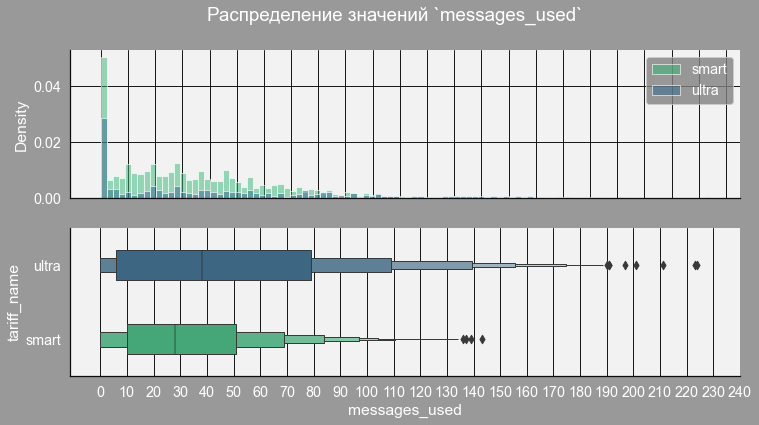

In [70]:
col = 'messages_used'
title = 'Число сообщений за месяц для абонентов разных тарифов'
xlim = np.arange(0,250,10)
show_stats_and_hist(col, title, xlim)

In [71]:
print(bold('Доля абонентов, которые редко пользуются смсками:'),
      np.round(len(joined_data.query('messages_used <= 5')) / len(joined_data)*100))

Доля абонентов, которые редко пользуются смсками: 21.0


**Количество сообщений**

В обеих группах относительно большое количество абонентов (суммарно 21% от всей выборки), которые редко пользуются смсками (отправляют меньше 5 смс в месяц). При этом абоненты тарифа Ультра в среднем используют смски активнее, чем абоненты Смарта (у Ультра выше среднее и медиана). При этом стандарное дисперсия у Ультра почти в три раза больше, потому что есть абоненты, которые фанатеют от смс (более 220 штук в месяц - это выброс, а дисперсия к выбросам неустойчива).

Интернет трафик за месяц для абонентов разных тарифов
                                   smart  ultra
выборочное среднее                  16.4   19.5
выборочная дисперсия                33.2   97.3
выборочное стандартное отклонение    5.8    9.9


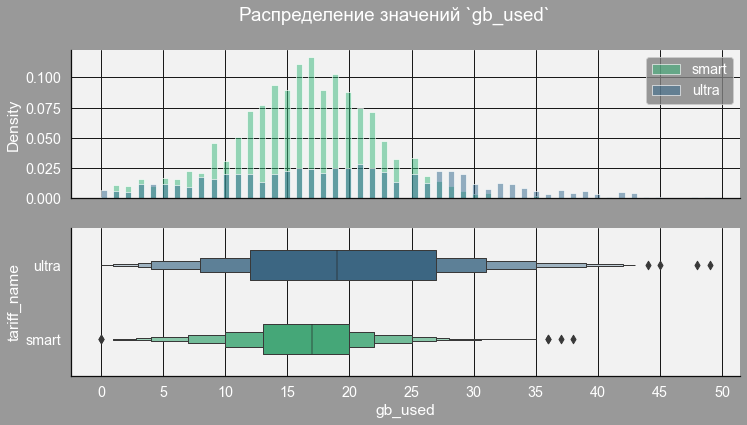

In [72]:
col = 'gb_used'
title = 'Интернет трафик за месяц для абонентов разных тарифов'
xlim = np.arange(0,51,5)
show_stats_and_hist(col, title, xlim)

**Интернет-трафик**

Пользователи более дорогого тарифа Ультра в среднем (судя по среднему и медиане) используют больше Гб трафика в месяц. Однако разнородность этой выборки гораздо выше (больше и дисперсия, и стандартное отклонение). По форме гистограмы это тоже видно: у абонентов Смарта она более узкая, значения тяготеют к среднему, а у абонентов Ультра она гораздо более плоская. В целом (кроме отсутствия высокого бина около 0) это распределение напоминает распределение минут по форме.

----

# Проверка гипотез о средних выручках

### средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

**Сначала посмотрим, как распределена выручка от абонентов внутри одного тарифа**

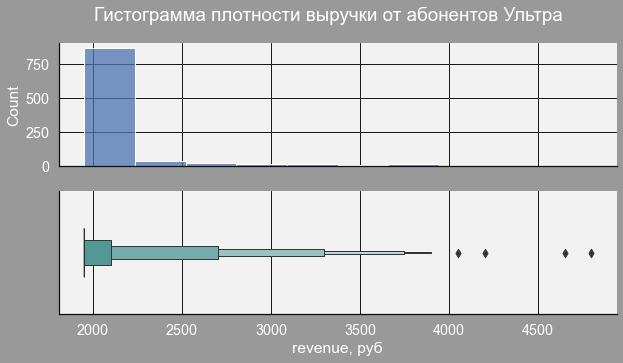

In [73]:
plot_hist_and_box_for_column(data=ultra_data,
                             column_name='revenue',
                             label=', руб',
                             bins=10)
plt.suptitle('Гистограмма плотности выручки от абонентов Ультра')
plt.show()

In [74]:
print(bold('Доля абонентов Ультра, которым не хватает тарифного пакета:'),
      np.round(len(ultra_data.query('revenue > 1950'))/len(ultra_data)*100, 2))

Доля абонентов Ультра, которым не хватает тарифного пакета: 13.6


Почти всем абонентам Ультра хватает пакетов, включенных в абонентскую плату. Но встречаются и те, кому не хватает (13.6%).

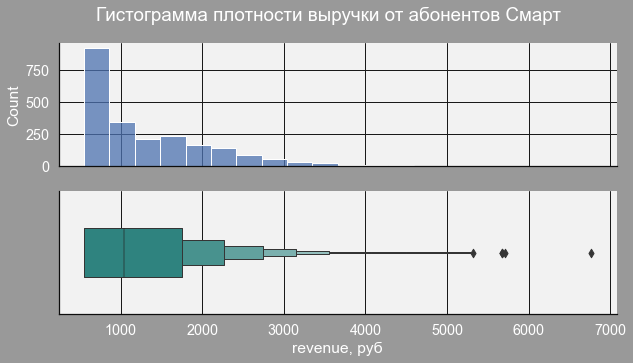

In [75]:
plot_hist_and_box_for_column(data=smart_data,
                             column_name='revenue',
                             label=', руб',
                             bins=20)
plt.suptitle('Гистограмма плотности выручки от абонентов Смарт')
plt.show()

In [76]:
print(bold('Доля абонентов Смарт, которым хватает тарифного пакета:'),
      np.round(len(smart_data.query('revenue < 551'))/len(smart_data)*100, 2))

Доля абонентов Смарт, которым хватает тарифного пакета: 25.3


В тарифе Смарт только 25.3% пользователей укладывается в абоненстскую плату, а остальным приходится доплачивать, кому-то даже очень много. Возможно, нужно предложить им сменить тариф (хотя это не в интересах компании, конечно).

    H0: средние выручки равны.
    H1: средние не равны (двусторонняя альтернатива).
Считаем, что пользователи разных тарифов - люди из двух разных генеральных совокупностей, то есть выборки независимы.


Будем использовать t-критерий Стьюдента для проверки гипотезы о равенстве средних двух независимых выборок.

Но прежде чем произвести проверку гипотезы через t-критерий Стьюдента проведем проверку дисперсии выборок, чтобы понять с каким параметром `equal_var` использовать метод проверки `ttest_ind` (по дефолту True).

In [77]:
print('Дисперсия значений выручки от абонентов Смарт {:.2f}, выборки абонентов Ультра {:.2f}'.format(smart_data['revenue'].var(), ultra_data['revenue'].var()))

Дисперсия значений выручки от абонентов Смарт 673931.32, выборки абонентов Ультра 143491.24


Кажется, дисперсии отличаются. Проверим гипотезу о равенстве дисперсий тестом Левене, так как распределения не кажутся нормальными и тест Бартлета не подойдет (H0: дисперсии равны):

In [78]:
alpha=0.05
s, pvalue = st.levene(smart_data['revenue'], ultra_data['revenue'])
print('p-значение:', pvalue)
if (pvalue < alpha):
    print(bold('Отвергаем нулевую гипотезу'))
else:
    print(bold('Не получилось отвергнуть нулевую гипотезу')) 

p-значение: 1.6855369377883898e-124
Отвергаем нулевую гипотезу


Критерий Левене отвергает нулевую гипотезу о равенстве дисперсий генеральных совокупностей, из которых были взяты выборки. Теперь проверим гипотезу о равенстве средних с параметром `equal_var=False`:

In [79]:
results = st.ttest_ind(smart_data['revenue'], ultra_data['revenue'], equal_var=False)
alpha = 0.05
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print(bold('Отвергаем нулевую гипотезу'))
else:
    print(bold('Не получилось отвергнуть нулевую гипотезу')) 

p-значение: 2.7240946993530856e-246
Отвергаем нулевую гипотезу


То, что мы наблюдаем в выборках, не могло случится (очень маленький pvalue) при справедливости нулевой гипотезы. То есть средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

### средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [80]:
replace_dict  = {city: 'Другие' for city in joined_data.query('city != "Москва"')['city'].unique()}
joined_data['city_r'] = joined_data['city'].replace(replace_dict)
joined_data['city_r'].unique()

array(['Другие', 'Москва'], dtype=object)

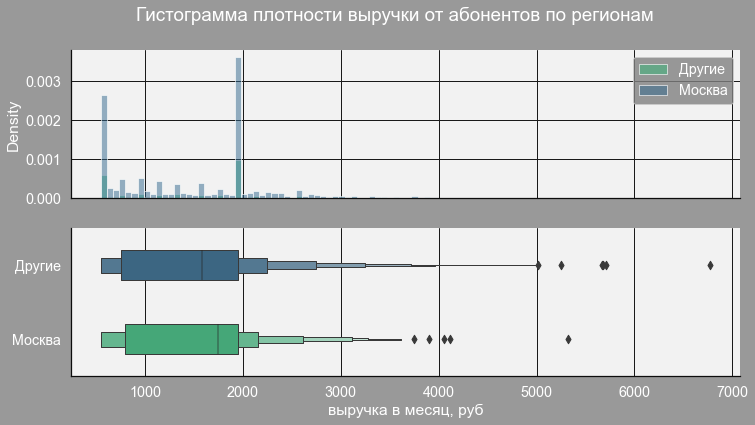

In [81]:
fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True)
sns.histplot(data=joined_data,
             x='revenue',
             hue='city_r',
             stat='density',
             bins=100,
             palette='viridis',
             ax=ax[0])
    
ax[0].legend(['Другие','Москва'], facecolor='0.5')
    
sns.boxenplot(data=joined_data,
              x='revenue',
              y='city_r',
              palette='viridis',
              width = 0.4,
              ax=ax[1])
ax[1].set_xlabel('выручка в месяц, руб')
ax[1].set_ylabel('')
sns.despine()
plt.suptitle('Гистограмма плотности выручки от абонентов по регионам')
plt.show()

    H0: средние выручки равны.
    H1: средние не равны (двусторонняя альтернатива).
Считаем, что пользователи из разных городов - люди из двух разных генеральных совокупностей, то есть выборки независимы.

Будем использовать t-критерий Стьюдента для проверки гипотезы о равенстве средних двух независимых выборок.

Сначала проверим гипотезу о равенстве дисперсий выборок (генеральных совокупностей, откуда взяты выборки):

In [82]:
alpha=0.05
s, pvalue = st.levene(joined_data.query('city == "Москва"')['revenue'],
                      joined_data.query('city != "Москва"')['revenue'])
print('p-значение:', pvalue)
if (pvalue < alpha):
    print(bold('Отвергаем нулевую гипотезу'))
else:
    print(bold('Не получилось отвергнуть нулевую гипотезу')) 

p-значение: 0.009373921759468934
Отвергаем нулевую гипотезу


Дисперсии не равны, исходя из этого проверяем гипотезу о равенстве средней выручки от Москвичей и остальных:

In [83]:
results = st.ttest_ind(joined_data.query('city == "Москва"')['revenue'],
                       joined_data.query('city != "Москва"')['revenue'],
                      equal_var=False)
alpha = 0.05
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print(bold('Отвергаем нулевую гипотезу'))
else:
    print(bold('Не получилось отвергнуть нулевую гипотезу')) 

p-значение: 0.5126564657748214
Не получилось отвергнуть нулевую гипотезу


То, что мы наблюдаем в выборках, можно наблюдать при условии справедливости H0, поэтому оснований для ее отвержения нет, то есть нельзя утверждать, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

----

# Выводы

1. На счет поведения пользователей по использованию услуг оператора можно сказать следующее:
    * Среди абонентов обоих тарифов 21% людей отправляют меньше 5 смс в месяц.
    
    * Абоненты тарифа Ультра в среднем используют смски активнее, чем абоненты Смарта(среднее число смс в месяц у абонентов Ультра *49.4 шт/мес*, среднее для Смарта *33.4 шт/мес*) *(здесь и ниже шт == минуты/сообщения/гибабайты)*.
    
    * При этом дисперсия количества сообщений у Ультра почти в три раза больше (*2285.3* против *796.8* у Смарта), потому что есть абоненты, которые отправляют более 220 штук в месяц, а дисперсия к выбросам неустойчива.
    
    * Пользователи более дорогого тарифа Ультра также в среднем больше разговаривают и используют интернет трафик (например, среднее используемое количество минут равно *526.6 шт/мес* против *417.9 шт/мес* у абонентов Смарта). Однако разнородность выборки абонентов Ультра по этим показателям здесь снова выше (например, стандарное отклонение количества минут в месяц равно *317.6 шт/мес*, против *190.3 шт/мес* у Смарта).


2. Проверка статистических гипотез t-критерием Стьюдента на уровне доверия 5% показала, что 
    * На основании предоставленной выборки нельзя сказать, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
    * При этом средняя выручка от пользователей тарифов «Ультра» и «Смарт» статистически различается.


3. На основании проведенного анализа можно сказать, что тариф Ультра выгоднее для компании, даже не смотря на то, что 75% абонентов тарифа Смарт переплачивают сверх тарифа.